# Short Term Load Forecasting
Here we perform ML based experiment for hourly load forcasting for given parameters (or features).

In [609]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import time
import gc

**Colab Config**

In [610]:
# from google.colab import drive 
# drive.mount ("/content/drive/")

## Architecture of the Work 

$ \fbox{Load Datasets} -->  \fbox{Feature Engineering}  --> \fbox{Data Processing} --> \fbox{Train-Val-Test Split} --> \fbox{Model Training} --> \fbox{Prediction}$ 



## Load Dataset

In this work ISO-NE dataset has been considered. Dataset is taken from this work:
https://github.com/yalickj/load-forecasting-resnet

In [611]:
df_master = pd.read_csv('dataset/selected_data_ISONE.csv') #in laptop
# df_master = pd.read_csv('/content/drive/MyDrive/selected_data_ISONE.csv') #in colab

In [612]:
df_master.head()

,date,year,month,day,weekday,hour,demand,temperature
0,2003/3/1,2003,3,1,7,1,12863.0,23
1,2003/3/1,2003,3,1,7,2,12389.0,22
2,2003/3/1,2003,3,1,7,3,12155.0,21
3,2003/3/1,2003,3,1,7,4,12072.0,21
4,2003/3/1,2003,3,1,7,5,12160.0,22


In [613]:
print("Number of Samples:",df_master.shape[0])
print("Number of Days:" ,len(df_master.date.unique()))

Number of Samples: 103776
Number of Days: 4324


### Data Analysis

In [614]:
df_temp_2014 = df_master[df_master.year==2014]

In [615]:
df_temp_2014

,date,year,month,day,weekday,hour,demand,temperature
95016,2014/1/1,2014,1,1,4,1,13821.0,20
95017,2014/1/1,2014,1,1,4,2,13280.0,19
95018,2014/1/1,2014,1,1,4,3,12885.0,17
95019,2014/1/1,2014,1,1,4,4,12729.0,17
95020,2014/1/1,2014,1,1,4,5,12779.0,17
...,...,...,...,...,...,...,...,...
103771,2014/12/31,2014,12,31,4,20,16955.0,22
103772,2014/12/31,2014,12,31,4,21,16243.0,21
103773,2014/12/31,2014,12,31,4,22,15525.0,21
103774,2014/12/31,2014,12,31,4,23,14759.0,18


<AxesSubplot:>

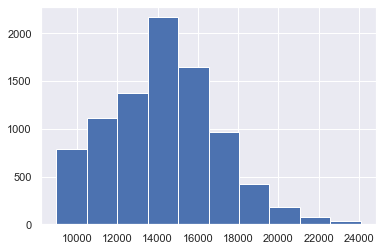

In [616]:
df_temp_2014.demand.hist() #histogram of samples

<AxesSubplot:>

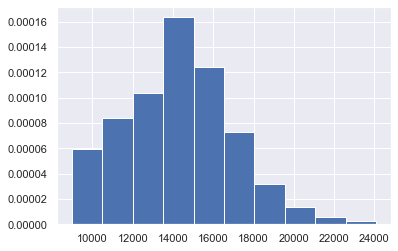

In [617]:
df_temp_2014.demand.hist(density=True) #probability density function

## Feature Engineering

The given dataset contains *year, month, day, weekday, hour, demand* and *temperature*. We are going to add *weekday, season* and *festival* into the dataset. We will consider previous hour load demand as an input.

In [618]:
df = df_master.copy()

In [619]:
df_master['prev_hour_demand'] = df_master['demand'].shift(1)

In [620]:
# add weekday info to the dataset
# the initial value for iter_weekday corresponds to the first day of the dataset
iter_weekday = 6
weekday = np.zeros((24*4324,))
for i in range(4324):
    mod = np.mod(iter_weekday, 7)
    for j in range(24):
        if (mod == 6) or (mod == 0):
            weekday[i*24 + j] = 0
        else:
            weekday[i*24 + j] = 1
    iter_weekday += 1

In [621]:
# add season and festival info to the dataset
import datetime
iter_date = datetime.date(2003, 3, 1)
season = np.zeros((24*4324,))
festival = np.zeros((24*4324,))
for i in range(4324):
    month = iter_date.month
    day = iter_date.day
    for j in range(24):
        if (month==4) | (month==5) | ((month==3) and (day>7)) | ((month==6) and (day<8)):
            season[i*24 + j] = 0 #spring
        elif (month==7) | (month==8) | ((month==6) and (day>7)) | ((month==9) and (day<8)):
            season[i*24 + j] = 1 #summer
        elif (month==10) | (month==11) | ((month==9) and (day>7)) | ((month==12) and (day<8)):
            season[i*24 + j] = 2 #autumn
        elif (month==1) | (month==2) | ((month==12) and (day>7)) | ((month==3) and (day<8)):
            season[i*24 + j] = 3 #winter

        if (month == 7) and (day == 4):
            festival[i*24 + j] = 1
        if (month == 11) and (iter_date.weekday() == 4) and (day + 7 > 30):
            festival[i*24 + j] = 1
        if (month == 12) and (day == 25):
            festival[i*24 + j] = 1
    iter_date = iter_date + datetime.timedelta(1)

In [622]:
df_master['weekday'] = weekday

In [623]:
df_master['season'] = season
df_master['season'] = df_master.apply(lambda x:int(x['season']),axis=1) # to keep it integer
df_master['festival'] = festival

## Data Processing
Before fitting data into neural networks model we will do some processing here. In this work demand values are normalized by peak demand value. Season and Month values are one-hot encodded.

List of freatures and their size are shown bellow.

### Features
* M - month = 1 to 12 (one-hot-encoded) - size 12
* W - weekday = 0 or 1 - size 1
* H - hour = 1 to 24  - size 1
* S - Season = 4 (one-hot-encoded) - size 4
* T - temp - size 1
* F - festival = 0 or 1 - size 1
* prev_hour_demand - deman at previous hour - size 1

Total Feature Size 21

In [624]:
 #feature and Target columns
FECOLS = ['month_1', 'month_2', 'month_3', 'month_4', 
          'month_5','month_6', 'month_7', 'month_8',
          'month_9', 'month_10','month_11','month_12',
          "weekday","hour", 'prev_hour_demand',
          'season_0', 'season_1','season_2', 'season_3',
          "festival","temperature"]
TGCOL = ["demand"]

In [625]:
df_onehot = pd.get_dummies(df_master,columns=["month","season"],prefix=["month","season"])
df_onehot.head(2)

,date,year,day,weekday,hour,demand,temperature,prev_hour_demand,festival,month_1,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,2003/3/1,2003,1,0.0,1,12863.0,23,NaN,0.0,0,...,0,0,0,0,0,0,0,0,0,1
1,2003/3/1,2003,1,0.0,2,12389.0,22,12863.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1


In [626]:
MAX_DEMAND = max(df_onehot.demand)

In [627]:
#normalizing demand value by peak value
df_onehot['demand'] = df_onehot.demand/MAX_DEMAND 
df_onehot['prev_hour_demand'] = df_onehot.prev_hour_demand/MAX_DEMAND

In [628]:
# print(X.shape,Y.shape)

Here the task is:

* Give the parameters of the given hours, model predict load demand for the given hours.

In [629]:
df_onehot.head()

,date,year,day,weekday,hour,demand,temperature,prev_hour_demand,festival,month_1,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,2003/3/1,2003,1,0.0,1,0.465680,23,NaN,0.0,0,...,0,0,0,0,0,0,0,0,0,1
1,2003/3/1,2003,1,0.0,2,0.448519,22,0.465680,0.0,0,...,0,0,0,0,0,0,0,0,0,1
2,2003/3/1,2003,1,0.0,3,0.440048,21,0.448519,0.0,0,...,0,0,0,0,0,0,0,0,0,1
3,2003/3/1,2003,1,0.0,4,0.437043,21,0.440048,0.0,0,...,0,0,0,0,0,0,0,0,0,1
4,2003/3/1,2003,1,0.0,5,0.440229,22,0.437043,0.0,0,...,0,0,0,0,0,0,0,0,0,1


In [630]:
X = df_onehot[FECOLS].values
y = df_onehot[TGCOL].values

In [631]:
print(X.shape,y.shape)

(103776, 21) (103776, 1)


In [632]:
#reshaping to train on LSTM
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
X.shape

(103776, 1, 21)

## Train-Val-Test Split

In [633]:
from sklearn.model_selection import train_test_split

#dataset splitted into train,val,test as 64%,16%,20%
X_train,X_test,Y_train,Y_test = train_test_split( X,y,test_size=0.2, random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split( X_train,Y_train,test_size=0.2, random_state=42)

## Model Loading and Analysis

In this section we will analyze the performance of trained neural network models.

In [634]:
from tensorflow.keras.layers import Dense,LSTM,Dropout, Concatenate
from tensorflow.keras import Sequential,Input, optimizers, losses, models, callbacks

In [635]:
from weights import model_functions as models

### ANN Model
ANN consists of 6 Dense Layers with activation function `selu`.

In [636]:
model1 = models.get_ann_model((1,21))
# model1.summary()

In [637]:
model1.load_weights('weights/model_ann/'+model1.name)

In [638]:
# scores = model1.evaluate(X_test, Y_test)
# print("TEST MAPE :",scores)

### LSTM-DENSE Model

Like ANN this model is also consists of 6 hidden layers. However, first 2 layers are replaced by LSTM layers and subsequent 4 layers are Dense layers. Activation function for dense layers is `selu`. 

In [639]:
model2 = models.get_lstm_model((1,21))
# model2.summary()

In [640]:
model2.load_weights('weights/model_lstm_dense/'+model2.name)

### LSTM-DENSE Ensemble

4 different LSTM-Dense model is parallaly trained and concatenated to make the prediction. 4 models are internally different.

First model:
* consist of `selu` activation fucntion for dense layers.  kernel_initializer=`glorot_uniform`,

Second model: 
* consist of `elu` activation fucntion for dense layers.  kernel_initializer=`glorot_uniform`,

Third model: 
* consist of `gelu` activation fucntion for dense layers.  kernel_initializer=`random_normal`,

Forth model: 
* consist of `softplus` activation fucntion for dense layers.  kernel_initializer=`random_normal`,

Finally, the last layers of these models are concatenated and pass it to the final layer to make predictions. The main idea is that these 4 models will learn input features differently so that the model as a whole can gain better generalization capability.


In [641]:
model3 = models.get_lstm_model_ensemble((1,21))
# model3.summary()

In [642]:
model3.load_weights('weights/model_lstm_dense_ensemble/'+model3.name)

### Performance Summary 

We have performed a range of experiments for this task with changing layers, activation functions, hyperparameters tuning, etc. The finnal models output are summarized bellow. 


LSTM-DENSE
* 300 Epochs | Best at 280 loss: 0.8526 - val_loss: 0.7045 | TEST MAPE : 0.6746

LSTM-DENSE-ENSEMBLE 
* 300 Epochs | Best at 277 loss: 0.8177 - val_loss: 0.6609 | TEST MAPE : 0.6466


ANN 
* 300 Epochs | Best at 261 loss: 0.8558 - val_loss: 0.7126 | TEST MAPE : 0.6997


In [643]:
import json

In [644]:
#loading training history of the models 

f = open('weights/model_ann/history.json')
ann_history = json.load(f)

f = open('weights/model_lstm_dense/history.json')
lstm_dense_history = json.load(f)

f = open('weights/model_lstm_dense_ensemble//history.json')
lstm_dense_ensemble_history = json.load(f)


In [645]:
ann_loss = ann_history['loss']
ann_val_loss = ann_history['val_loss']

lstm_loss = lstm_dense_history['loss']
lstm_val_loss = lstm_dense_history['val_loss']

lstm_ensemble_loss=  lstm_dense_ensemble_history['loss']
lstm_ensemble_val_loss=  lstm_dense_ensemble_history['val_loss']

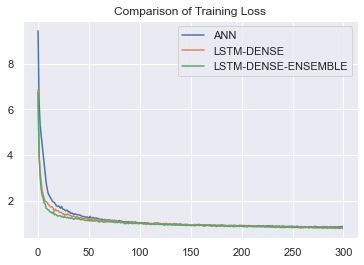

In [646]:
plt.figure()
plt.title('Comparison of Training Loss')
plt.plot(ann_loss)
plt.plot(lstm_loss)
plt.plot(lstm_ensemble_loss)
plt.legend(['ANN','LSTM-DENSE','LSTM-DENSE-ENSEMBLE'])

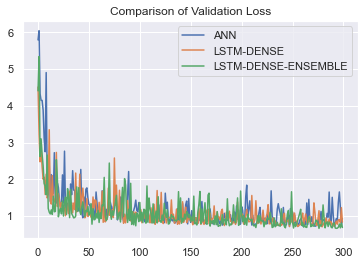

In [647]:
plt.figure()
plt.title('Comparison of Validation Loss')
plt.plot(ann_val_loss)
plt.plot(lstm_val_loss)
plt.plot(lstm_ensemble_val_loss)
plt.legend(['ANN','LSTM-DENSE','LSTM-DENSE-ENSEMBLE'])

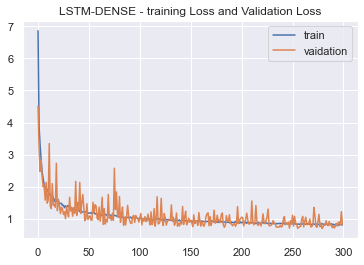

In [648]:
plt.figure()
plt.title('LSTM-DENSE - training Loss and Validation Loss')
plt.plot(lstm_loss)
plt.plot(lstm_val_loss)
plt.legend(['train','vaidation'])

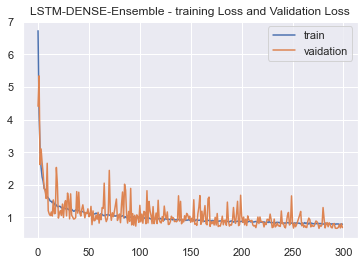

In [649]:
plt.figure()
plt.title('LSTM-DENSE-Ensemble - training Loss and Validation Loss')
plt.plot(lstm_ensemble_loss)
plt.plot(lstm_ensemble_val_loss)
plt.legend(['train','vaidation'])

## Visualization


In [650]:
def visualize_day(df_onehot,date,model=None,dense_only=False):
    #extracting data for the given date
    temp = df_onehot[df_onehot.date==date]
    temp_x = temp[FECOLS].values #input features
    temp_y = temp[TGCOL].values * MAX_DEMAND #true demands
    temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

    #prediction
    preds = model.predict(temp_x)
    if dense_only:
        preds = np.reshape(preds,(24,1))

    y_preds = preds * MAX_DEMAND #predicted demands
    plt.figure()
    plt.plot(temp_y)
    plt.plot(y_preds)
    plt.legend(["actual","predicted"])
    plt.title(date)

## LSTM-DENSE

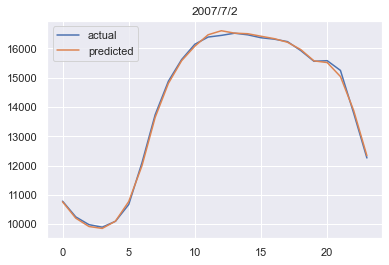

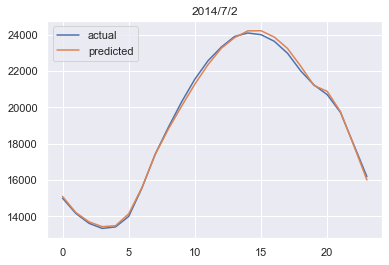

In [651]:
visualize_day(df_onehot,date='2007/7/2',model=model2)
visualize_day(df_onehot,date='2014/7/2',model=model2)

## LSTM-DENSE Ensemble

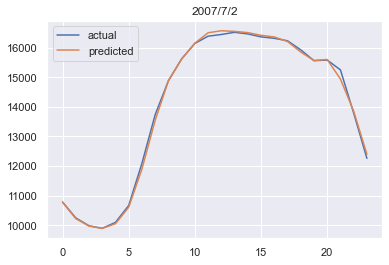

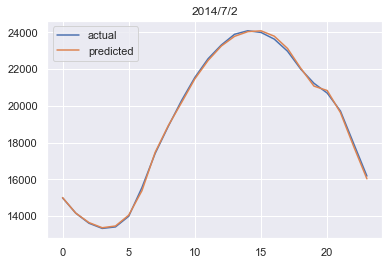

In [652]:
visualize_day(df_onehot,date='2007/7/2',model=model3)
visualize_day(df_onehot,date='2014/7/2',model=model3)

## Visualization for 1 week

In [653]:
#extracting 1 week data for the given year and month
temp = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]
temp = temp[0:168]

temp_x = temp[FECOLS].values #input features
temp_y = temp[TGCOL].values * MAX_DEMAND #true demands
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))


<ipython-input-653-c33c1a1d9667>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


## ANN

In [654]:
#prediction
preds = model1.predict(temp_x)
preds = np.reshape(preds,(168,1))
y_preds = abs(preds) * MAX_DEMAND #predicted demands

Text(0.5, 1.0, '2014 January')

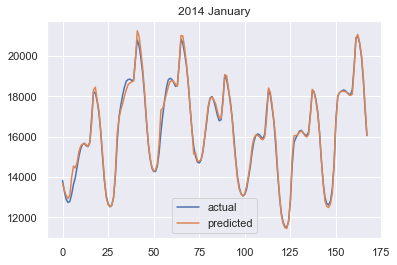

In [655]:
plt.figure()
plt.plot(temp_y)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## LSTM-DENSE

In [656]:
#prediction
preds = model2.predict(temp_x)
y_preds = abs(preds) * MAX_DEMAND #predicted demands

Text(0.5, 1.0, '2014 January')

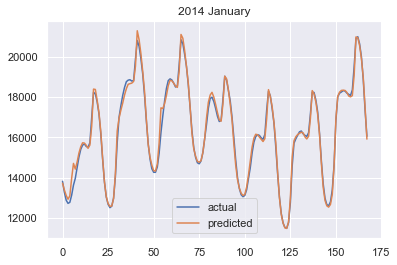

In [657]:
plt.figure()
plt.plot(temp_y)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## LSTM-DENSE Ensemble

In [658]:
#prediction
preds = model3.predict(temp_x)
y_preds = abs(preds) * MAX_DEMAND #predicted demands

Text(0.5, 1.0, '2014 January')

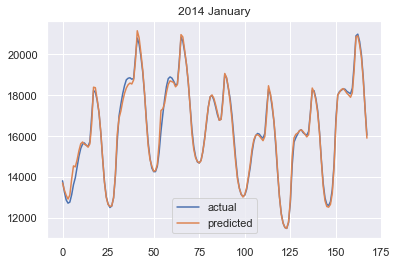

In [659]:
plt.figure()
plt.plot(temp_y)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## Performance Analysis

In [682]:
temp_2014_january = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]

<ipython-input-682-469edaa302a0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_2014_january = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


In [683]:
temp_x = temp_2014_january[FECOLS].values #input features
temp_y = temp_2014_january[TGCOL].values * MAX_DEMAND #true demands
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

In [684]:
preds = model3.predict(temp_x)

In [685]:
temp_2014_january['predicted'] = preds

In [689]:
temp_2014_january

,date,year,day,weekday,hour,demand,temperature,prev_hour_demand,festival,month_1,...,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,predicted
95016,2014/1/1,2014,1,1.0,1,0.500362,20,0.528745,0.0,1,...,0,0,0,0,0,0,0,0,1,0.496472
95017,2014/1/1,2014,1,1.0,2,0.480776,19,0.500362,0.0,1,...,0,0,0,0,0,0,0,0,1,0.483997
95018,2014/1/1,2014,1,1.0,3,0.466476,17,0.480776,0.0,1,...,0,0,0,0,0,0,0,0,1,0.474728
95019,2014/1/1,2014,1,1.0,4,0.460828,17,0.466476,0.0,1,...,0,0,0,0,0,0,0,0,1,0.468059
95020,2014/1/1,2014,1,1.0,5,0.462638,17,0.460828,0.0,1,...,0,0,0,0,0,0,0,0,1,0.475175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95755,2014/1/31,2014,31,1.0,20,0.619542,36,0.637137,0.0,1,...,0,0,0,0,0,0,0,0,1,0.621209
95756,2014/1/31,2014,31,1.0,21,0.598436,35,0.619542,0.0,1,...,0,0,0,0,0,0,0,0,1,0.595240
95757,2014/1/31,2014,31,1.0,22,0.567917,34,0.598436,0.0,1,...,0,0,0,0,0,0,0,0,1,0.560467
95758,2014/1/31,2014,31,1.0,23,0.526790,34,0.567917,0.0,1,...,0,0,0,0,0,0,0,0,1,0.517856


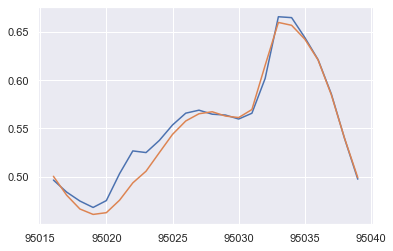

In [687]:
plt.plot(temp_2014_january['predicted'][0:24])
plt.plot(temp_2014_january['demand'][0:24])

Text(0.5, 1.0, 'Actual load and 95% prediction intervals for January 2014')

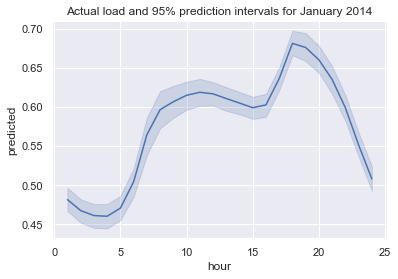

In [709]:
sns.lineplot(x='hour',y='predicted',data=temp_2014_january,ci=95)
plt.title('Actual load and 95% prediction intervals for January 2014')

<AxesSubplot:xlabel='hour', ylabel='predicted'>

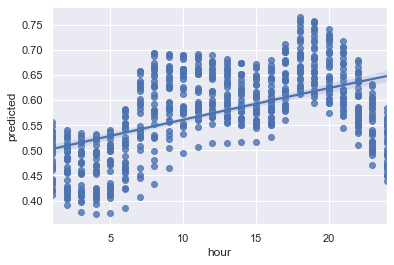

In [705]:
sns.regplot(x='hour',y='predicted',data=temp_2014_january,logistic=True)

In [72]:
from tensorflow.keras.losses import MeanAbsolutePercentageError as mape

In [95]:
loss_object = mape()

In [168]:
def analysis(year=2014):
    df = df_onehot[df_onehot.year==year]
    x_fe = df[FECOLS].values
    y_true = df[TGCOL].values
    x_fe = np.reshape(x_fe,(x_fe.shape[0],1,x_fe.shape[1]))
    
    #prediction
    y_preds = model3.predict(x_fe)
    
    plt.figure()
    plt.title(str(year))
    plt.plot(y_true[0:24])
    plt.plot(y_preds[0:24])
    plt.legend(["actual","predicted"])
    
    losses = []
    for i in range(y_true.shape[0]):
        loss = loss_object(y_true[i],y_preds[i])
        losses.append(loss.numpy())
    
    #confidence interval calculation
    n = len(losses)
    std = np.std(losses)
    mean = np.mean(losses)

    alpha = 0.05
    DF = n-1
    t = 1.96
    SE = std/np.sqrt(n)
    
    CI = t*SE
    print(f'At Year {year} Confidence Interval {CI}')

At Year 2014 Confidence Interval 0.017065315807532698
At Year 2013 Confidence Interval 0.016767343045491594
At Year 2012 Confidence Interval 0.017179240478695977
At Year 2011 Confidence Interval 0.017212361237803116


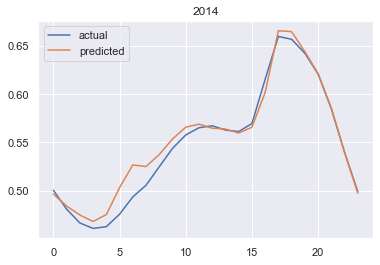

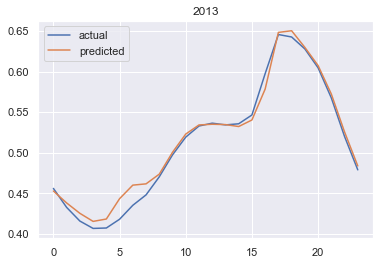

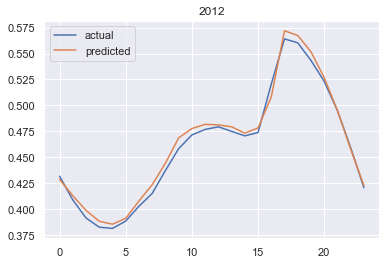

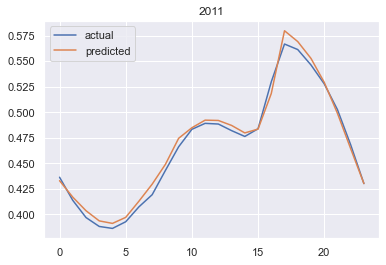

In [169]:
analysis(2014)
analysis(2013)
analysis(2012)
analysis(2011)


In [170]:
# model3.evaluate(x_fe,y_true)

## Extrapolate for Different Duration 

#### Extrapolation Analysis for 2014

In [585]:
temp = df_onehot[df_onehot.year==2014]
temp.reset_index(drop=True,inplace=True)
temp.head()

,date,year,day,weekday,hour,demand,temperature,prev_hour_demand,festival,month_1,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,2014/1/1,2014,1,1.0,1,0.500362,20,0.528745,0.0,1,...,0,0,0,0,0,0,0,0,0,1
1,2014/1/1,2014,1,1.0,2,0.480776,19,0.500362,0.0,1,...,0,0,0,0,0,0,0,0,0,1
2,2014/1/1,2014,1,1.0,3,0.466476,17,0.480776,0.0,1,...,0,0,0,0,0,0,0,0,0,1
3,2014/1/1,2014,1,1.0,4,0.460828,17,0.466476,0.0,1,...,0,0,0,0,0,0,0,0,0,1
4,2014/1/1,2014,1,1.0,5,0.462638,17,0.460828,0.0,1,...,0,0,0,0,0,0,0,0,0,1


In [586]:
temp_x = temp[FECOLS].values
temp_y = temp[TGCOL].values

In [587]:
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

In [589]:
scores = model2.evaluate(temp_x, temp_y)
print("TEST MAPE :",scores)

274/274 [==============================] - 3s 6ms/step - loss: 0.7050
TEST MAPE : 0.6905785799026489


In [590]:
df_extrapolate = temp.copy()
start_demand = df_extrapolate.iloc[0].prev_hour_demand

In [591]:
df_extrapolate.prev_hour_demand = 0
df_extrapolate['predicted'] = 0
df_extrapolate.loc[0,'prev_hour_demand'] = start_demand

In [592]:
df_extrapolate.head()

,date,year,day,weekday,hour,demand,temperature,prev_hour_demand,festival,month_1,...,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,predicted
0,2014/1/1,2014,1,1.0,1,0.500362,20,0.528745,0.0,1,...,0,0,0,0,0,0,0,0,1,0
1,2014/1/1,2014,1,1.0,2,0.480776,19,0.000000,0.0,1,...,0,0,0,0,0,0,0,0,1,0
2,2014/1/1,2014,1,1.0,3,0.466476,17,0.000000,0.0,1,...,0,0,0,0,0,0,0,0,1,0
3,2014/1/1,2014,1,1.0,4,0.460828,17,0.000000,0.0,1,...,0,0,0,0,0,0,0,0,1,0
4,2014/1/1,2014,1,1.0,5,0.462638,17,0.000000,0.0,1,...,0,0,0,0,0,0,0,0,1,0


In [593]:
from tqdm import tqdm

In [594]:
for index in tqdm(range(df_extrapolate.shape[0])):
    sample = df_extrapolate[index:index+1]
    X = sample[FECOLS].values
    X = np.reshape(X,(X.shape[0],1,X.shape[1]))
    
    pred = model2.predict(X)
    
    #storing values in dataframe
    df_extrapolate.loc[index,'predicted'] = pred.tolist()[0][0]
    df_extrapolate.loc[index+1,'prev_hour_demand'] = pred.tolist()[0][0]
    

100%|██████████| 8760/8760 [09:11<00:00, 15.90it/s]


In [595]:
df_extrapolate.head()

,date,year,day,weekday,hour,demand,temperature,prev_hour_demand,festival,month_1,...,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,predicted
0,2014/1/1,2014.0,1.0,1.0,1.0,0.500362,20.0,0.528745,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.496994
1,2014/1/1,2014.0,1.0,1.0,2.0,0.480776,19.0,0.496994,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.481826
2,2014/1/1,2014.0,1.0,1.0,3.0,0.466476,17.0,0.481826,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.475962
3,2014/1/1,2014.0,1.0,1.0,4.0,0.460828,17.0,0.475962,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.476829
4,2014/1/1,2014.0,1.0,1.0,5.0,0.462638,17.0,0.476829,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.489944


In [596]:
gc.collect()

40225

### A Week Ahead

In [597]:
week = df_extrapolate[0:7*24]

In [598]:
y_true = week['demand'].dropna()
y_pred = week['predicted'].dropna()

In [599]:
loss = loss_object(y_true,y_pred)
loss.numpy()

4.909548282623291

### A Month Ahead

In [600]:
month = df_extrapolate[0:30*24]

In [601]:
y_true = month['demand'].dropna()
y_pred = month['predicted'].dropna()

In [602]:
loss = loss_object(y_true,y_pred)
loss.numpy()

3.0868172645568848

### A Year Ahead

In [603]:
y_true = df_extrapolate['demand'].dropna()
y_pred = df_extrapolate['predicted'].dropna()

In [604]:
loss = loss_object(y_true,y_pred)
loss.numpy()

3.355276107788086

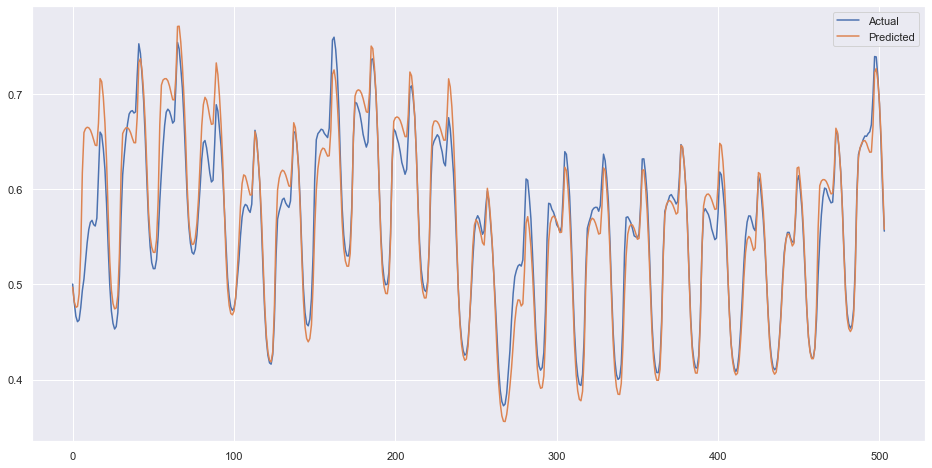

In [605]:
plt.figure(figsize=(16,8))
plt.plot(y_true[0:504])
plt.plot(y_pred[0:504])
plt.legend(['Actual','Predicted'])

In [606]:
losses = []
for i in range(1,13):
    m_str = "month_"+str(i)
    y_true = df_extrapolate[df_extrapolate[m_str]==1]['demand'].dropna()
    y_pred = df_extrapolate[df_extrapolate[m_str]==1]['predicted'].dropna()
    loss = loss_object(y_true,y_pred)
    losses.append(loss.numpy())

In [607]:
losses

[3.1603126525878906,
 3.88786244392395,
 3.8340158462524414,
 3.211622476577759,
 3.02962327003479,
 2.798731803894043,
 3.5101892948150635,
 3.8007876873016357,
 4.361410140991211,
 2.030022621154785,
 3.4307782649993896,
 3.2718019485473633]

Text(0, 0.5, 'MAPE')

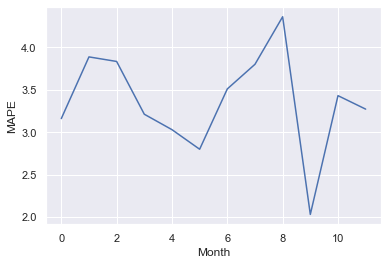

In [608]:
plt.plot(losses)
plt.xlabel('Month')
plt.ylabel('MAPE')
